Word2vec is one of the most popular techniques to learn word embeddings. The idea behind word2vec was that the meaning of a word is determined by the context in which it occurs. A word embedding is a learned representation for text where words that have the same meaning have a similar representation.

**Word2vec** model has 2 architectures:

1. **Continuous bag of word (CBOW):**

    CBOW predicts the center word from the surrounding context words.

2. **Skip-gram:**

    Skip-gram predicts surrounding context words from the center word.

#### SkipGram from Scratch

In [1]:
# !pip install portalocker #make sure you install the library and restart the session
# !pip uninstall torch torchtext numpy -y
# !pip install torch==1.13.1 torchtext==0.14.1
# !pip install torchdata==0.5.1
# !pip install datasets
# !pip install numpy==1.26.4

Found existing installation: torch 1.13.1
Uninstalling torch-1.13.1:
  Successfully uninstalled torch-1.13.1
Found existing installation: torchtext 0.14.1
Uninstalling torchtext-0.14.1:
  Successfully uninstalled torchtext-0.14.1
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached torch-1.13.1-cp310-cp310-manylinux1_x86_64.whl.metadata (24 kB)
  Using cached torchtext-0.14.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.9 kB)
  Using cached numpy-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached torch-1.13.1-cp310-cp310-manylinux1_x86_64.whl (887.5 MB)
Using cached torchtext-0.14.1-cp310-cp310-manylinux1_x86_64.whl (2.0 MB)
Using cached numpy-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depe

In [2]:
# importing the necessary libraries
import torch
from functools import partial
import torch.nn as nn
from torch.utils.data import DataLoader
from torchtext.data import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
# from torchtext.datasets import WikiText2
from datasets import load_dataset

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import os
import numpy as np
import json
import argparse
import random
import re
from collections import Counter

/raid/home/sahilm/anaconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="6"

> **In the following code the add your hyperparameters for the network.**

In [4]:
# Initialization


"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please free to play with these hyperparameters to see the effects on the
# quality of generated embeddings


SKIPGRAM_N_WORDS = 3 # the length of the context on each side (k)

MIN_WORD_FREQUENCY = 60 # only words with a minimum word frequency considered
MAX_SEQUENCE_LENGTH = None # sentences with length more than this value truncated

EMBED_DIMENSION = 128 # dimension of the word2vec vectors

EMBED_MAX_NORM = None

In [5]:
def get_english_tokenizer():
    """
    Documentation:
    https://pytorch.org/text/stable/_modules/torchtext/data/utils.html#get_tokenizer
    """
    tokenizer = get_tokenizer("basic_english", language="en")
    return tokenizer

def get_data_iterator(ds_name, ds_type, data_dir):
    """
    input dataset used:
    https://paperswithcode.com/dataset/wikitext-2
    This is directly imported from PyTorch.
    """

    ds = load_dataset("Salesforce/wikitext", "wikitext-2-raw-v1", split=ds_type)
    text_data = [item['text'] for item in ds]
    # print(text_data[0])
    data_iter = to_map_style_dataset(text_data)

    # data_iter = WikiText2(root=data_dir, split=(ds_type))
    # data_iter = to_map_style_dataset(data_iter)

    return data_iter

def build_vocab(data_iter, tokenizer):
    """Builds vocabulary from iterator"""

    vocab = build_vocab_from_iterator(
        map(tokenizer, data_iter),
        specials=["<unk>"], #adding special tokens to the vocabulary
        min_freq=MIN_WORD_FREQUENCY,
    )
    vocab.set_default_index(vocab["<unk>"])
    return vocab

def collate_skipgram(batch, text_pipeline):
    batch_input, batch_output = [], []

    for text in batch:
        text_tokens_ids = text_pipeline(text)

        if len(text_tokens_ids) < SKIPGRAM_N_WORDS * 2 + 1:
            continue

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids)):
            center_word = text_tokens_ids[idx]
            context_words = text_tokens_ids[max(0, idx - SKIPGRAM_N_WORDS):idx] + \
                            text_tokens_ids[idx + 1:min(len(text_tokens_ids), idx + SKIPGRAM_N_WORDS + 1)]

            for context_word in context_words:
                batch_input.append(center_word)
                batch_output.append(context_word)

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)

    return batch_input, batch_output


def get_dataloader_and_vocab(
    model_name, ds_name, ds_type, data_dir, batch_size, shuffle, vocab=None
    ):
    """
    Prepares a DataLoader and builds a vocabulary for the dataset.
    model_name: Name of the model to be used
    ds_name: Name of the dataset
    ds_type: Type of the dataset (e.g., train, test)
    data_dir: Directory where the dataset is stored
    batch_size: Size of each batch
    vocab: An existing vocabulary, if available

    """

    data_iter = get_data_iterator(ds_name, ds_type, data_dir)
    tokenizer = get_english_tokenizer()

    if not vocab:
        vocab = build_vocab(data_iter, tokenizer)

    text_pipeline = lambda x: vocab(tokenizer(x))

    # collate_fn = collate_skipgram
    collate_fn = partial(collate_skipgram,text_pipeline=text_pipeline,)


    # creates a DataLoader for the dataset

    """
    dataloader documentation
    https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

    """
    dataloader = DataLoader(
        data_iter,
        batch_size=batch_size,
        shuffle=shuffle,
        # collate_fn=partial(collate_fn, text_pipeline=text_pipeline),
        collate_fn=collate_fn,
        )

    return dataloader, vocab


### Initialize the SkipGram Model

 **Complete the `initialization` and `forward` function in the following  SkipGram_Model class**

In [11]:
class SkipGram_Model(nn.Module):
    """
    Implementation of Skip-Gram model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size: int):
        super(SkipGram_Model, self).__init__()

        """define the embedding and the linear layer of the network"""
        # this is the initialization for the layers in the skipgram model

        # ADD YOUR CODE HERE
        if EMBED_MAX_NORM:
          self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=EMBED_DIMENSION, max_norm=EMBED_MAX_NORM)
        else:
          self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=EMBED_DIMENSION)
        self.linear = nn.Linear(in_features=EMBED_DIMENSION, out_features=vocab_size)
        # self.linear = nn.Embedding(num_embeddings=EMBED_DIMENSION, embedding_dim=vocab_size)

        # Initialize the weights of the embedding layer
        nn.init.xavier_uniform_(self.embedding.weight)
        # nn.init.uniform_(self.embedding.weight, a=0.0, b=0.5)

        # Initialize the weights of the linear layer
        nn.init.xavier_uniform_(self.linear.weight)
        # nn.init.uniform_(self.linear.weight, a=0.0, b=0.5)



    def forward(self, inputs_):
        """define forward function"""
        # ADD YOUR CODE HERE

        # return the output of your final layer to find the minimize the loss

        embedded = self.embedding(inputs_)
        logits = self.linear(embedded)
        return logits

    def get_word_embedding(self):
        """ return the associated word embeddings for center words """

        # ADD YOUR CODE HERE

        # return the normalized embeddings as a 2D numpy array (in word2vec models,
        # the vector associated with the center word is considered
        # word embedding)

        word_embeddings = self.embedding.weight.data.cpu().numpy()
        normalized_embeddings = word_embeddings / np.linalg.norm(word_embeddings, axis=1, keepdims=True)
        return normalized_embeddings

> **The following is the Trainer class for the skip-gram model. Add your code for the `training` and `validation` loops.**

In [12]:
class Trainer:
    """Main class for model training"""

    # NOTE: you are free to add additional inputs/functions
    # to the trainer class to make training better
    # make sure to define and add it within the input
    # and initialization if you are using any additional inputs
    # for usage in the function

    def __init__(self,model,epochs,train_dataloader,val_dataloader,criterion,optimizer,device,model_dir,model_name,):
        self.model = model
        self.epochs = epochs
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.model_dir = model_dir
        self.model_name = model_name
        self.loss = {"train": [], "val": []}
        self.model.to(self.device)
        # self.scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3)
        self.best_val_loss = np.inf


    # ADD YOUR CODE HERE FOR TRAINING & VALIDATION
    # This implementation need not include negative sampling.

    # NOTE: you can add additional functions to make training better

    def train(self):
      """Training loop"""
      for epoch in range(self.epochs):
            train_loss = self._train_epoch(epoch)
            val_loss = self.evaluate()

            # Adjust learning rate based on validation loss
            # self.scheduler.step(val_loss)

            print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Save model if validation loss has improved
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_model()

      # Save final loss
      self.save_loss()


    def _train_epoch(self, epoch):
        """Single epoch training"""
        self.model.train()
        running_loss = 0.0
        for inputs, targets in self.train_dataloader:
            inputs, targets = inputs.to(self.device), targets.to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(inputs)

            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

        # Calculate average training loss for the epoch
        train_loss = running_loss / len(self.train_dataloader)
        self.loss["train"].append(train_loss)
        return train_loss

    def evaluate(self):
        """Validation loop"""
        self.model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, targets in self.val_dataloader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                running_loss += loss.item()

        val_loss = running_loss / len(self.val_dataloader)
        self.loss["val"].append(val_loss)
        return val_loss

    def save_model(self):
        """
        Save final model to directory

        """
        model_path = os.path.join(self.model_dir, "model.pt")
        torch.save(self.model, model_path)

    def save_loss(self):
        """
        Save train/val loss as json file to the directory

        """
        loss_path = os.path.join(self.model_dir, "loss.json")
        with open(loss_path, "w") as fp:
            json.dump(self.loss, fp)

> **The following code block defines the various parameters and nomenclature for the training and saving of the skip-gram model. Add numerical values for the `specified hyperparameters`.**

In [13]:
# ADD YOUR CODE HERE
# CHANGE THE None VALUES TO YOUR DESIRED VALUES

model_name = 'skipgram'

dataset = 'WikiText2'
data_dir = './data/'
train_batch_size = 1
val_batch_size = 1
shuffle = True

optimizer = optimizer = optim.Adam
best_val_loss = float('inf')  # Initialize with a large value
best_val_loss = None
learning_rate = 0.001
epochs = 5

# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno

model_dir = 'LATHIYA_SAHIL_MANISHBHAI_22691'

In [14]:
# import shutil

# # Remove old directory if it exists
# if os.path.exists(model_dir):
#     shutil.rmtree(model_dir)

# # Create model directory
# os.makedirs(model_dir)

train_dataloader, vocab = get_dataloader_and_vocab(model_name=model_name,ds_name=dataset,ds_type="train",data_dir=data_dir,batch_size=train_batch_size,shuffle=shuffle,vocab=None,)

val_dataloader, _ = get_dataloader_and_vocab(model_name=model_name,ds_name=dataset,ds_type="validation",data_dir=data_dir,batch_size=val_batch_size,shuffle=shuffle,vocab=vocab,)

vocab_size = len(vocab.get_stoi())
print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 3530


> **The following code block is used to train and save the model. Add the code wherever required**

In [15]:
model_class = SkipGram_Model
model = model_class(vocab_size=vocab_size)

# ADD YOUR CODE HERE
# You'll have to specify the loss criterion
# Your loss function would depend upon whether you
# choose to train with negative sampling or not
# either of the two are valid choices

criterion = nn.CrossEntropyLoss()

# ADD YOUR CODE HERE
# You'll have to specify the optimizer here
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# NOTE: if you are **optionally** using additional options for the trainer
# (e.g., a training scheduler), please add them below.


trainer = Trainer(model=model,epochs=epochs,train_dataloader=train_dataloader,val_dataloader=val_dataloader,criterion=criterion,optimizer=optimizer,device=device,model_dir=model_dir,model_name=model_name,)

trainer.train()
print("Training finished.")

trainer.save_model()
trainer.save_loss()
vocab_path = os.path.join(model_dir, "vocab.pt")
torch.save(vocab, vocab_path)
print("Model artifacts saved to folder:", model_dir)

Epoch 1/5, Train Loss: nan, Val Loss: nan
Epoch 2/5, Train Loss: nan, Val Loss: nan
Epoch 3/5, Train Loss: nan, Val Loss: nan
Epoch 4/5, Train Loss: nan, Val Loss: nan
Epoch 5/5, Train Loss: nan, Val Loss: nan
Training finished.
Model artifacts saved to folder: LATHIYA_SAHIL_MANISHBHAI_22691


### Let us analyze the performance of the model

You'll be evaluated on the quality of the word representations as judged by the word similarity test, and word analogy tests.


In [16]:
#@title Evaluation

import numpy as np
import pandas as pd
import torch
import sys
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [17]:
# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno

folder = "LATHIYA_SAHIL_MANISHBHAI_22691"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the saved model
model = torch.load(f"{folder}/model.pt", map_location=device)
vocab = torch.load(f"{folder}/vocab.pt")
print(model)

SkipGram_Model(
  (embedding): Embedding(3530, 128)
  (linear): Linear(in_features=128, out_features=3530, bias=True)
)


In [18]:
word_embeddings = model.get_word_embedding()

# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno

# Save the embeddings to the folder
np.save('LATHIYA_SAHIL_MANISHBHAI_22691/word_embeddings.npy', word_embeddings)

Once the embeddings are trained, we can use a few words to evaluate some desirable properties of word representations.

For instance, whether similar words are indeed similar in the high-dimensional space?

In [19]:
words = ['king', 'queen', 'river', 'water', 'ocean', 'tree', 'plant', 'happy', 'glad', 'mother', 'daughter']

> **Write a code to find the similarity of the each word in words with eachother**

In [20]:
def get_word_similarity(words):
    """
    This function takes the words as input and outputs the word vectors
    corresponding to the words obtained from your word2vec model and the
    similarity of every word with each other.
    word2vec is the embedding matrix corresponding to the given words and
    this has to be returned as a numpy array to apply PCA on it whereas,
    w2v_similarity[i][j] should contain the similarity of word i with word j

    """
    # ADD YOUR CODE HERE

    # you'll have to compute the similarity matrix for the words given above
    # Initialize an empty list to store word vectors
    word_vectors = []

    # Iterate through the words to get their embeddings
    for word in words:
        # Get the embedding vector for the word from your word2vec model
        # Assuming you have a function get_embedding(word) that returns the embedding for a word
        try:
          embedding = model.get_word_embedding()[vocab[word]]
          word_vectors.append(embedding)
        except KeyError:
            print(f"Word '{word}' not found in the word2vec model.")
            # If word not found, use zero vector as placeholder
            word_vectors.append(np.zeros_like(model.get_word_embedding()[vocab['is']]))

    # Convert the list of word vectors to a numpy array
    word2vec = np.array(word_vectors)

    w2v_similarity = cosine_similarity(word2vec)
    np.fill_diagonal(w2v_similarity, 0)

    return word2vec, w2v_similarity

word2vec, w2v_similarity = get_word_similarity(words)

Let us visualize this similarity matrix. The similarity of each word with other words in words is displayed as a pandas dataframe and as a heatmap

In [21]:
pd.DataFrame(w2v_similarity, columns = words, index = words)

,king,queen,river,water,ocean,tree,plant,happy,glad,mother,daughter
king,0.000000,0.499311,0.341778,0.093786,0.001442,0.087722,0.087634,0.158050,0.277747,0.338615,0.366607
queen,0.499311,0.000000,0.293994,0.134136,0.117744,0.140923,0.041714,0.063016,0.269097,0.385757,0.293349
river,0.341778,0.293994,0.000000,0.428460,0.375998,0.317738,0.274023,0.087248,0.286160,0.142851,0.071761
water,0.093786,0.134136,0.428460,0.000000,0.399596,0.348424,0.444572,0.097065,0.367812,0.096702,0.003794
ocean,0.001442,0.117744,0.375998,0.399596,0.000000,0.396672,0.280191,0.079256,0.202996,-0.035306,-0.041917
tree,0.087722,0.140923,0.317738,0.348424,0.396672,0.000000,0.496122,0.203867,0.334892,0.224416,0.190963
plant,0.087634,0.041714,0.274023,0.444572,0.280191,0.496122,0.000000,0.082223,0.181744,0.089089,0.028570
happy,0.158050,0.063016,0.087248,0.097065,0.079256,0.203867,0.082223,0.000000,0.087291,0.234396,0.293322
glad,0.277747,0.269097,0.286160,0.367812,0.202996,0.334892,0.181744,0.087291,0.000000,0.275767,0.158642
mother,0.338615,0.385757,0.142851,0.096702,-0.035306,0.224416,0.089089,0.234396,0.275767,0.000000,0.595856


<Axes: >

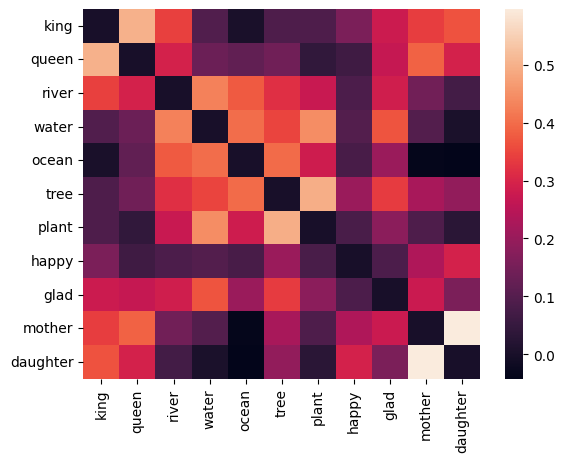

In [22]:
sns.heatmap(pd.DataFrame(w2v_similarity, columns = words, index = words))

The size of the words embedding are reduced to to 2D and displayed as a scatterplot for analysis

In [23]:
# Create a 2-dimensional PCA model of the word vectors using the scikit-learn PCA class
# n_components in PCA specifies the no.of dimensions
pca = PCA(n_components=2)

# Fit and transform the vectors using PCA model
reduced_w2v = pca.fit_transform(word2vec)

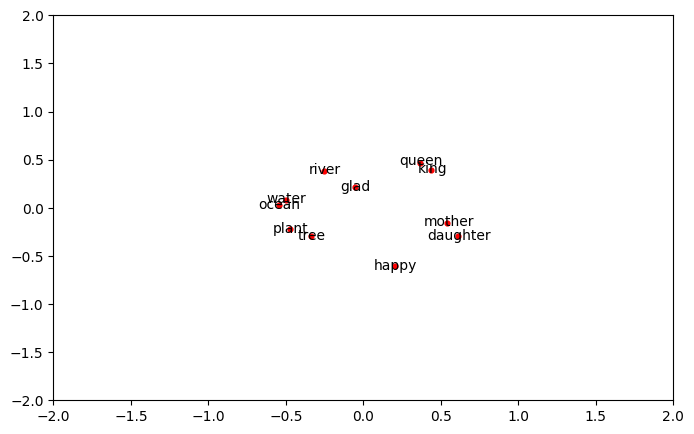

In [24]:
plt.figure(figsize=(8,5))
plt.scatter(reduced_w2v[:,0],reduced_w2v[:,1], s = 12, color = 'red')
plt.xlim([-2,2])
plt.ylim([-2,2])
x, y = reduced_w2v[:,0] , reduced_w2v[:,1]
offset = 0.5
for i in range(len(x)):
    label = words[i]
    xi, yi = x[i], y[i]
    plt.annotate(label, (xi, yi), xytext=(xi + offset, yi + offset),
                 textcoords='offset points', ha='center', va='center')

plt.savefig("word_similarity.png")

The 10 most similar word to the given word is calculated in the following code blocks

In [25]:
def get_top_similar(word: str, topN: int = 10):

    """
    This function calculates the topN words similar to the input word.
    If the word is not in vocabulary, then similarity is not calculated.
    If the word is in the vocabulary, then the dot product of the embedding
    matrix and the word vector is calculated. The topN words are selected.
    """
    word_id = vocab[word]
    if word_id == 0:
        print("Out of vocabulary word")
        return

    word_vec = model.get_word_embedding()[word_id]

    word_vec = np.reshape(word_vec, (len(word_vec), 1))

    dists = np.matmul(model.get_word_embedding(), word_vec).flatten()
    topN_ids = np.argsort(-dists)[1 : topN + 1]

    topN_dict = {}
    for sim_word_id in topN_ids:
        sim_word = vocab.lookup_token(sim_word_id)
        topN_dict[sim_word] = dists[sim_word_id]

    return topN_dict

In [26]:
for word, sim in get_top_similar("india").items():
   print("EVALUATION: most similar words to {}: {:.3f}".format(word, sim))

EVALUATION: most similar words to archaeological: 0.552
EVALUATION: most similar words to survey: 0.544
EVALUATION: most similar words to somalia: 0.536
EVALUATION: most similar words to china: 0.524
EVALUATION: most similar words to varanasi: 0.514
EVALUATION: most similar words to sites: 0.488
EVALUATION: most similar words to capital: 0.488
EVALUATION: most similar words to haifa: 0.486
EVALUATION: most similar words to argentina: 0.482
EVALUATION: most similar words to africa: 0.480


### Analogy Tests

Analogy tests include questions of the format a:b::x:?, such tests are used to intrinsically evaluate the quality of word vectors.

Here's one example.

In [27]:
def get_analogy(word_1, word_2, word_3):

  """
  top 5 most analgous vector calculated correspond to a set similar to
  man: woman :: king: ? . This is calculated similar to the above case.

  """

  emb1 = model.get_word_embedding()[vocab[word_1]]
  emb2 = model.get_word_embedding()[vocab[word_2]]
  emb3 = model.get_word_embedding()[vocab[word_3]]

  emb4 = emb1 - emb2 + emb3

  # compute dot products between 'emb4' and all word embeddings in the model.
  emb4 = np.reshape(emb4, (len(emb4), 1))
  dot_product = np.matmul(model.get_word_embedding(), emb4).flatten()

  top5 = np.argsort(-dot_product)[:5]

  return top5, dot_product

top5_analogy, dot_product = get_analogy('king', 'man', 'woman')

for word_id in top5_analogy:
    print("{}: {:.3f}".format(vocab.lookup_token(word_id), dot_product[word_id]))

king: 0.949
supreme: 0.712
henry: 0.665
governor: 0.636
lord: 0.622


The model performance will be evaluated based on an analogy output for the top 5 words. The following code will used to evaluate the performance of the model on the analogies dataset. We will measure how often the correct answer is a part of the top 5 options.

In [28]:
# Downloading the file containing a few analogies.
# We will change the contents of this file while testing.

# !wget -O analogies.txt "https://drive.google.com/uc?export=download&id=1jHx25dECegjtRKBB587nEfHiJesrH0g2"

In [29]:
import random
random.seed(42)

def load_and_sample_analogies(file_path, sample_size=5000):
    with open(file_path, 'r') as file:
        analogies = []
        cnt = 0
        for line in file:
            # Split the line into words and ensure it has exactly 4 elements
            parts = line.strip().split()
            if len(parts) == 4:
                analogies.append(parts)
                cnt +=1
        # Sample analogies
        sampled_analogies = random.sample(analogies, min(sample_size, len(analogies)))
        # sampled_analogies = analogies
        print("cnt: ",cnt)
        return sampled_analogies

# Path to your text file
# NOTE: analogies used for grading could be slightly different
file_path = 'analogies.txt'

# Load and sample analogies
sampled_analogy_dataset = load_and_sample_analogies(file_path)

cnt:  9582


In [30]:
def get_word_id(word, vocab):
    """check for out of vocabulary items"""
    return vocab[word] if word in vocab else 0

def analogy_score(analogy_dataset):
    """
    The top5 analogous words calculated for each set of words for your
    implementation of word2vec and compared with an existing dataset to
    calculate if the expected word is in the first 5 predictions.
    """
    
    correct = 0
    total = 0
    # not_accounted_in_acc = 0
    for a, b, c, d in analogy_dataset:
        # Convert words to lowercase
        a, b, c, d = a.lower(), b.lower(), c.lower(), d.lower()

        # Check if any word is out of vocabulary
        if 0 in [get_word_id(word, vocab) for word in [a, b, c, d]]:
            # not_accounted_in_acc += 1
            continue

        #finding the first five words that are analogous to the given set
        top5_analogy, dot_product = get_analogy(c,a,b)

        predicted_words = []

        for word_id in top5_analogy:
            word = vocab.lookup_token(word_id)
            predicted_words.append(word)

        if d in predicted_words:
            correct += 1

        total += 1

    # print("Total: ", len(analogy_dataset))
    # print("not_accounted_in_acc: ", not_accounted_in_acc)
    # print("accounted_in_acc: ", len(analogy_dataset) - not_accounted_in_acc)
    precision_at_5 = correct / total if total > 0 else 0
    return precision_at_5

precision_at_5 = analogy_score(sampled_analogy_dataset)
print("EVALUATION: Precision at 5 for the analogy test is", precision_at_5)

EVALUATION: Precision at 5 for the analogy test is 0.3756218905472637


#### Google's word2vec for comparison

In the following code blocks, the pretained word2vec developed by Google is used to analyze the quality of the embedding. The word2vec model can be downloaded from [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing).

In [31]:
# !wget -O GoogleNews-vectors-negative300.bin "https://drive.google.com/uc?export=download&id=12Oicgl5scdJLR7t8jbzKpW6o8QkYOylg"
!wget --no-check-certificate 'https://drive.usercontent.google.com/download?id=12Oicgl5scdJLR7t8jbzKpW6o8QkYOylg&export=download&authuser=0&confirm=t&uuid=99ffa115-71d1-4603-8ada-24aecd5754f2&at=AO7h07fIUUdOJz8VSxBtMbbK1Izw%3A1727111383325' -O GoogleNews-vectors-negative300.bin

--2024-09-24 00:40:42--  https://drive.usercontent.google.com/download?id=12Oicgl5scdJLR7t8jbzKpW6o8QkYOylg&export=download&authuser=0&confirm=t&uuid=99ffa115-71d1-4603-8ada-24aecd5754f2&at=AO7h07fIUUdOJz8VSxBtMbbK1Izw%3A1727111383325
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.192.97, 2404:6800:4009:82a::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.192.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3644258522 (3.4G) [application/octet-stream]
Saving to: ‘GoogleNews-vectors-negative300.bin’

GoogleNews-vectors- 100%[===================>]   3.39G  35.9MB/s    in 2m 28s  

2024-09-24 00:43:13 (23.5 MB/s) - ‘GoogleNews-vectors-negative300.bin’ saved [3644258522/3644258522]



In [32]:
import bs4
import requests
import tqdm.auto as tqdm

def download_from_drive(drive_link, target_path):
    response = requests.get(drive_link, stream=True)
    response.raise_for_status()
    if 'html' in response.headers['Content-Type']:
        response = requests.get(drive_link)
        response.raise_for_status()
        page = bs4.BeautifulSoup(response.text, features="lxml")
        if form := page.find('form', id='download-form'):
            id   = form.select_one("input[name='id']")['value']
            uuid = form.select_one("input[name='uuid']")['value']
            data = { 'confirm': 't', 'export': 'download', 'id': id, 'uuid': uuid }
            response = requests.get(page.find('form')['action'], params=data, stream=True)
            response.raise_for_status()
    with open(target_path, 'wb+') as file:
        with tqdm.tqdm(
            total=int(response.headers['Content-Length']),
            unit='B', unit_scale=True, unit_divisor=1024
        ) as pbar:
            for chunk in response.iter_content(chunk_size=4096):
                file.write(chunk)
                pbar.update(len(chunk))
    print("Downloaded to", target_path)

drive_link = "https://drive.google.com/uc?export=download&id=12Oicgl5scdJLR7t8jbzKpW6o8QkYOylg"
target_path = "GoogleNews-vectors-negative300.bin"

# download_from_drive(drive_link, target_path)

In [33]:
import gensim

# Load Google news 300 vectors file
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=500000)

In [34]:
# List of words to plot the embeddings
words = ['king', 'queen', 'river', 'water', 'ocean', 'tree', 'plant', 'happy', 'glad', 'mother', 'daughter']

> **Write a code to find the similarity of the each word in words with eachother using original word2vec**

In [35]:
from gensim.models import KeyedVectors
import numpy as np
def get_word_similarity(words,word2vec_model_path='GoogleNews-vectors-negative300.bin'):
    """
    This function takes the words as input and outputs the word vectors
    corresponding to the words using Google's word2vec and the similarity of
    every word with eachother. word2vec is the embedding matrix for the words
    given above w2v_similarity[i][j] should contain the similarity of word i with j

    """
    # ADD YOUR CODE HERE

    # you'll have to compute the similarity matrix for the words given above
    # Load the pre-trained word2vec model
    word2vec_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)

    # Initialize an empty list to store word vectors
    word_vectors = []

    # Iterate through the words to get their embeddings
    for word in words:
        if word in word2vec_model:
            embedding = word2vec_model[word]
            word_vectors.append(embedding)

    # Convert the list of word vectors to a numpy array
    word2vec = np.array(word_vectors)

    # Compute the similarity matrix for the words
    w2v_similarity = np.zeros((len(words), len(words)))
    for i in range(len(words)):
        for j in range(len(words)):
            if i != j:
                similarity = word2vec_model.similarity(words[i], words[j])
                w2v_similarity[i][j] = similarity

    return word2vec, w2v_similarity

word2vec, w2v_similarity = get_word_similarity(words)

The similarity of each word with other words in words is displayed as a pandas dataframe and as a heatmap

In [36]:
import pandas as pd
import seaborn as sns
pd.DataFrame(w2v_similarity, columns = words, index = words)

,king,queen,river,water,ocean,tree,plant,happy,glad,mother,daughter
king,0.000000,0.651096,0.086155,0.035606,0.065263,0.109141,0.057788,0.113239,0.063524,0.160052,0.148813
queen,0.651096,0.000000,0.103566,0.018264,0.099157,0.112222,0.088803,0.121214,0.082538,0.288445,0.305139
river,0.086155,0.103566,0.000000,0.576898,0.477181,0.230746,0.201330,0.073289,0.071341,0.131063,0.116944
water,0.035606,0.018264,0.576898,0.000000,0.471691,0.196022,0.271738,0.067675,0.085623,0.110723,0.079457
ocean,0.065263,0.099157,0.477181,0.471691,0.000000,0.141859,0.067005,-0.000511,0.014122,0.105623,0.081207
tree,0.109141,0.112222,0.230746,0.196022,0.141859,0.000000,0.265187,0.076933,0.105760,0.188985,0.173518
plant,0.057788,0.088803,0.201330,0.271738,0.067005,0.265187,0.000000,-0.010519,-0.000679,0.148805,0.092466
happy,0.113239,0.121214,0.073289,0.067675,-0.000511,0.076933,-0.010519,0.000000,0.740889,0.119672,0.152536
glad,0.063524,0.082538,0.071341,0.085623,0.014122,0.105760,-0.000679,0.740889,0.000000,0.125566,0.181102
mother,0.160052,0.288445,0.131063,0.110723,0.105623,0.188985,0.148805,0.119672,0.125566,0.000000,0.870623


<Axes: >

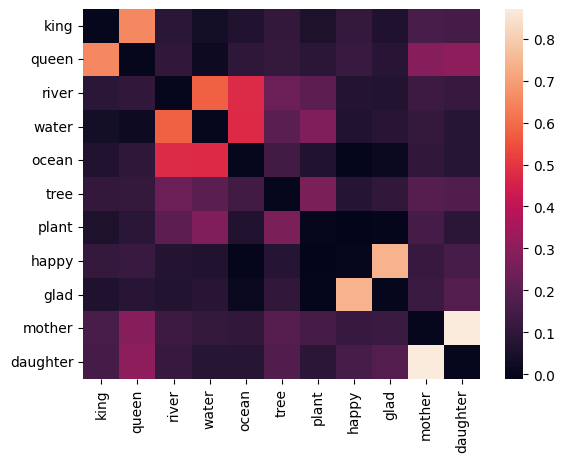

In [37]:
sns.heatmap(pd.DataFrame(w2v_similarity, columns = words, index = words))

The size of the words embedding are reduced to to 2D and displayed as a scatterplot for analysis

In [38]:
#PCA on word2vec embedding
pca = PCA(n_components=2)

reduced_w2v = pca.fit_transform(word2vec)

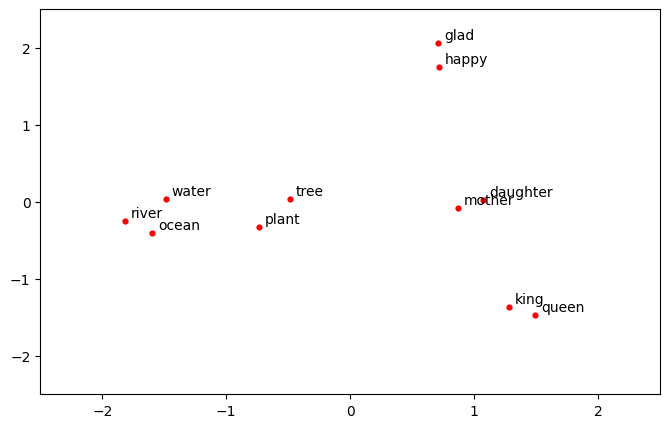

In [39]:
#plotting reduced order embeddings in a 2-D space

plt.figure(figsize=(8,5))
plt.scatter(reduced_w2v[:,0],reduced_w2v[:,1], s = 12, color = 'red')
plt.xlim([-2.5,2.5])
plt.ylim([-2.5,2.5])
x, y = reduced_w2v[:,0] , reduced_w2v[:,1]
for i in range(len(x)):
    plt.annotate(words[i],xy=(x[i], y[i]),xytext=(x[i]+0.05,y[i]+0.05))

In [40]:
model.most_similar('india')

[('indian', 0.6967039704322815),
 ('usa', 0.6836211085319519),
 ('pakistan', 0.681516706943512),
 ('chennai', 0.6675503253936768),
 ('america', 0.6589399576187134),
 ('sri_lanka', 0.64982008934021),
 ('canada', 0.6490967869758606),
 ('australia', 0.6368584036827087),
 ('mexico', 0.6239137649536133),
 ('uk', 0.6221641898155212)]

Analogy test

In [41]:
def analogy(x1, x2, y1): #defining analogy function
    result = model.most_similar(positive=[y1, x2], negative=[x1], topn = 5)
    return result

In [42]:
analogy('man', 'king', 'woman')

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581)]

In [43]:
def analogy_score(analogy_dataset):

    """
    The top5 analogous words calculated for each set of words for Google's
    word2vec and compared with an existing dataset to calculate if the word
    is in the first 5 predictions.

    """
    correct = 0
    total = 0

    for a, b, c, d in analogy_dataset:
        # Convert words to lowercase
        a, b, c, d = a.lower(), b.lower(), c.lower(), d.lower()

        words_scores = analogy(a,b,c)

        predicted_words = [item[0] for item in words_scores]

        if d in predicted_words:
            correct += 1

        total += 1

    precision_at_5 = correct / total if total > 0 else 0
    return precision_at_5

precision_at_5_Google = analogy_score(sampled_analogy_dataset)
print("EVALUATION: Precision at 5 for the analogy test with Google skip-gram model is", precision_at_5_Google)

EVALUATION: Precision at 5 for the analogy test with Google skip-gram model is 0.8748
